In [ ]:
%cd /content/drive/My\ Drive/DigiLab

/content/drive/My Drive/DigiLab


In [ ]:
!apt-get install swig -y
!pip install Cython numpy
!pip install arff
# sometimes you have to run the next command twice on colab
# I haven't figured out why
!pip install auto-sklearn

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd

In [ ]:
import os
import matplotlib.pyplot as plt
from random import sample
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from IPython.display import Image   
from pydotplus import graph_from_dot_data
import sklearn

In [ ]:
from autosklearn.experimental.askl2 import AutoSklearn2Classifier

In [ ]:
Xevents = pd.read_csv('train_events.csv')
Xcustom = pd.read_csv('train_customers.csv')

testcustom = pd.read_csv('live_customers.csv')
testevents = pd.read_csv('live_events.csv')

In [ ]:
%%time
sns_plot = sns.pairplot(Xcustom, height=2.5)
sns_plot.savefig("output_train.png")

%%time
sns_plot = sns.pairplot(testcustom, height=2.5)
sns_plot.savefig("output_test.png")

In [ ]:
Xcustom.apply(lambda x: sum(x.isnull()), axis=0)

id                               0
gender                           0
tenure_days                      0
age                              0
primary_address_city             0
italian_citizenship_dummy        0
student_dummy                    0
worker_dummy                     0
promo_dummy                      0
love_dummy                       0
estinction_date              49797
churn_dummy                      0
dtype: int64

In [ ]:
Xevents.apply(lambda x: sum(x.isnull()), axis=0)

ids_id        0
tp_mov_gk     0
co_naz_iso    0
dv_mov        0
im_mov        0
tipo_carta    0
new_dt_ope    0
dtype: int64

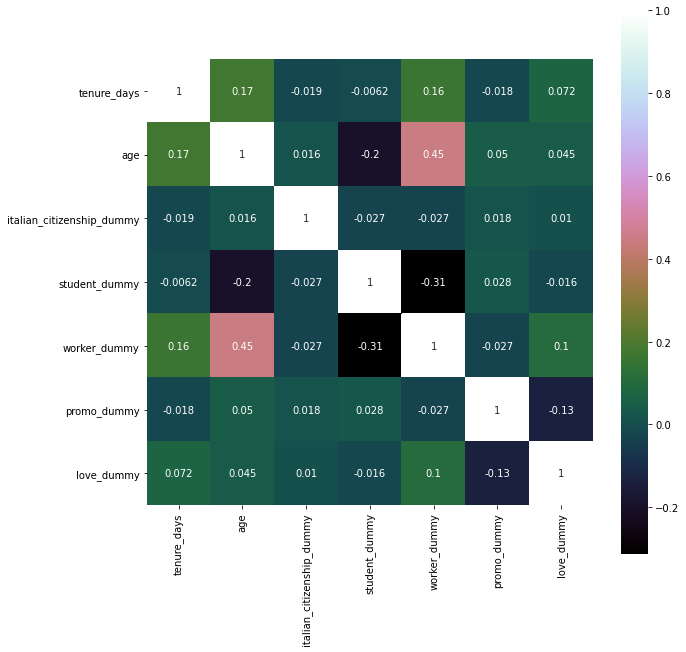

In [ ]:
correlation = Xcustom.loc[:, Xcustom.columns != 'churn_dummy'].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

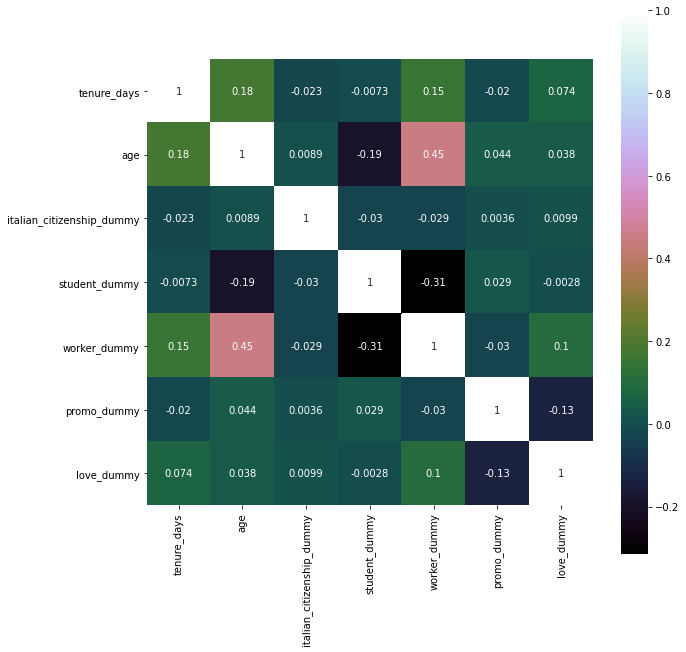

In [ ]:
correlation = testcustom.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

In [ ]:
def gendr(gen):
    if gen == 'M':
        return 1
    else:
        return 0      

In [ ]:
Xcustom['gender'] = Xcustom.gender.apply(gendr)

testcustom['gender'] = testcustom.gender.apply(gendr)

In [ ]:
ids = Xcustom.groupby('primary_address_city').count().sort_values('id')[['id']]
ids

,id
primary_address_city,
FRASCATI,15
ROVERETO,15
SAN GIOVANNI ROTONDO,17
CASSINO,19
ABANO TERME,20
...,...
NAPOLI,957
TORINO,1230
MILANO,3059


In [ ]:
tids = testcustom.groupby('primary_address_city').count().sort_values('id')[['id']]
tids

,id
primary_address_city,
TREVIGLIO,18
CESANO BOSCONE,18
MONTEBELLUNA,18
CHIERI,19
SAN GIUSEPPE VESUVIANO,19
...,...
NAPOLI,948
TORINO,1194
MILANO,3095


In [ ]:
dummies = Xcustom.groupby('primary_address_city').sum()[['churn_dummy']].sort_values('churn_dummy')
dummies

,churn_dummy
primary_address_city,
VOGHERA,0
MARTINA FRANCA,0
MASCALUCIA,0
MASSA,0
MASSAFRA,0
...,...
VERONA,5
TORINO,5
MILANO,8


In [ ]:
dcoef = ids.merge(dummies, how = 'left', right_on='primary_address_city', left_on='primary_address_city').reset_index()
dcoef.sort_values('churn_dummy').tail(10)

,primary_address_city,id,churn_dummy
182,MOLFETTA,48,3
215,PISTOIA,57,3
328,PALERMO,686,3
329,NAPOLI,957,3
319,ALTAMURA,237,4
330,TORINO,1230,5
326,VERONA,444,5
331,MILANO,3059,8
332,ROMA,3296,12
333,*,20134,79


In [ ]:
city_list = list(dcoef[dcoef['churn_dummy']>3]['primary_address_city'])
city_list

['ALTAMURA', 'VERONA', 'TORINO', 'MILANO', 'ROMA', '*']

In [ ]:
def city(ct):
    if ct in city_list:
        return ct
    else: return 'province'

In [ ]:
Xcustom['primary_address_city_group'] = Xcustom['primary_address_city'].apply(city)
Xcustom.head()

,id,gender,tenure_days,age,primary_address_city,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,estinction_date,churn_dummy,primary_address_city_group
0,038MOS113T9d1b319LY8AbIe,1,487,37,MILANO,1,0,1,0,0,NaN,0,MILANO
1,8fMOfafc2ST63aL6416a0YAI,1,621,28,*,1,0,1,0,0,NaN,0,*
2,eM7Oe36ec66f8STbL9Y01A5I,1,246,20,*,1,0,0,0,0,NaN,0,*
3,430Mf93OSf8T953LbYb3A6I7,1,63,28,*,1,0,0,1,0,NaN,0,*
4,ef63MaOSe0T16LYA152I3f47,1,519,29,*,1,1,0,1,0,NaN,0,*


In [ ]:
testcustom['primary_address_city_group'] = testcustom['primary_address_city'].apply(city)
testcustom.head()

,id,gender,tenure_days,age,primary_address_city,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,estinction_date,primary_address_city_group
0,MO1b8S0c091T13LY552a8AId,0,396,26,PALERMO,1,0,0,0,0,NaN,province
1,a7M5c44OSbTLdY368A571I18,0,463,67,MILANO,1,0,1,1,0,NaN,MILANO
2,d27bd2M7512OS8TaLabYAdI4,1,29,22,*,1,0,0,0,0,NaN,*
3,0c524b2c4MOSb4T8Lcf9YAI0,0,58,23,TERNI,1,0,0,1,0,NaN,province
4,2M66O815S91303359TLYA5I7,1,540,35,BELLUNO,1,0,1,1,1,NaN,province


In [ ]:
dcoef['primary_address_city_group'] = dcoef['primary_address_city'].apply(city)
dummyc = dcoef.groupby('primary_address_city_group').sum().reset_index()
dummyc['dc'] = dummyc['churn_dummy']/dummyc['id']
dummyc = dummyc.drop(['id', 'churn_dummy'], axis = 1)
dummyc.head()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,primary_address_city_group,dc
0,*,0.003924
1,ALTAMURA,0.016878
2,MILANO,0.002615
3,ROMA,0.003641
4,TORINO,0.004065


In [ ]:
Xcustom = Xcustom.drop(['primary_address_city', 'estinction_date'], axis = 1)
Xcustom.head()

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,churn_dummy,primary_address_city_group
0,038MOS113T9d1b319LY8AbIe,1,487,37,1,0,1,0,0,0,MILANO
1,8fMOfafc2ST63aL6416a0YAI,1,621,28,1,0,1,0,0,0,*
2,eM7Oe36ec66f8STbL9Y01A5I,1,246,20,1,0,0,0,0,0,*
3,430Mf93OSf8T953LbYb3A6I7,1,63,28,1,0,0,1,0,0,*
4,ef63MaOSe0T16LYA152I3f47,1,519,29,1,1,0,1,0,0,*


In [ ]:
testcustom['target'] = testcustom.apply(lambda x: 0 if pd.isna(x['estinction_date']) else 1, axis=1)

In [ ]:
testcustom = testcustom.drop(['primary_address_city', 'estinction_date'], axis = 1)
testcustom.head()

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,primary_address_city_group,target
0,MO1b8S0c091T13LY552a8AId,0,396,26,1,0,0,0,0,province,0
1,a7M5c44OSbTLdY368A571I18,0,463,67,1,0,1,1,0,MILANO,0
2,d27bd2M7512OS8TaLabYAdI4,1,29,22,1,0,0,0,0,*,0
3,0c524b2c4MOSb4T8Lcf9YAI0,0,58,23,1,0,0,1,0,province,0
4,2M66O815S91303359TLYA5I7,1,540,35,1,0,1,1,1,province,0


In [ ]:
Xcustom['primary_address_city_group'] = 'cities_' + Xcustom['primary_address_city_group'].astype(str)
testcustom['primary_address_city_group'] = 'cities_' + testcustom['primary_address_city_group'].astype(str)

In [ ]:
one_hot_cities = pd.get_dummies(Xcustom['primary_address_city_group'])
Xcustom = Xcustom.join(one_hot_cities)

In [ ]:
one_hot_cities = pd.get_dummies(testcustom['primary_address_city_group'])
testcustom = testcustom.join(one_hot_cities)

In [ ]:
testcustom.head()

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,primary_address_city_group,target,cities_*,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province
0,MO1b8S0c091T13LY552a8AId,0,396,26,1,0,0,0,0,cities_province,0,0,0,0,0,0,0,1
1,a7M5c44OSbTLdY368A571I18,0,463,67,1,0,1,1,0,cities_MILANO,0,0,0,1,0,0,0,0
2,d27bd2M7512OS8TaLabYAdI4,1,29,22,1,0,0,0,0,cities_*,0,1,0,0,0,0,0,0
3,0c524b2c4MOSb4T8Lcf9YAI0,0,58,23,1,0,0,1,0,cities_province,0,0,0,0,0,0,0,1
4,2M66O815S91303359TLYA5I7,1,540,35,1,0,1,1,1,cities_province,0,0,0,0,0,0,0,1


In [ ]:
Xcustom = Xcustom.drop(['primary_address_city_group', 'cities_*'], axis=1)
testcustom = testcustom.drop(['primary_address_city_group', 'cities_*'], axis=1)

###Начинаем работать с транзакциями

In [ ]:
Xevents['new_dt_ope'] = pd.to_datetime(Xevents['new_dt_ope'], format='%Y-%m-%d %H:%M:%S' )
testevents['new_dt_ope'] = pd.to_datetime(testevents['new_dt_ope'], format='%Y-%m-%d %H:%M:%S' )

In [ ]:
Xevents['today_dt']=Xevents.new_dt_ope.max()
testevents['today_dt']=testevents.new_dt_ope.max()

In [ ]:
Xevents['day_diff']=(Xevents['today_dt']-Xevents.new_dt_ope).dt.days
testevents['day_diff']=(testevents['today_dt']-testevents.new_dt_ope).dt.days

In [ ]:
df_1 = Xevents.groupby('ids_id').min()[['day_diff']].reset_index()
df_1.rename(columns={'day_diff': 'last_txn_d'}, inplace=True)
df_1.head()

,ids_id,last_txn_d
0,000MO9200ST0dL28cbYAfI22,9
1,00275MO17S0T9LYbbf08AI0d,10
2,002MO5dSTL981Y5476Af1d4I,30
3,002MedO23efS9TL708Y7AbId,1
4,00393feMOS01a2Td13dLYAeI,8


In [ ]:
tdf_1 = testevents.groupby('ids_id').min()[['day_diff']].reset_index()
tdf_1.rename(columns={'day_diff': 'last_txn_d'}, inplace=True)
tdf_1.head()

,ids_id,last_txn_d
0,000MecbO0ca0b0SaaT72LYAI,42
1,000b81cM7cO2S2T8LfaY43AI,0
2,000c6MOSaTbf1LY5A3bI051e,2
3,001Mdc0O87STeLY8AdbIb290,12
4,001MfO4bS1b57TLYAeI985fd,18


In [ ]:
df_2 =Xevents[Xevents.day_diff<=30].groupby('ids_id').count()[['day_diff']].reset_index()
df_2.rename(columns={'day_diff': 'count_txn_30d'}, inplace=True)
df_2.head()

,ids_id,count_txn_30d
0,000MO9200ST0dL28cbYAfI22,5
1,00275MO17S0T9LYbbf08AI0d,2
2,002MO5dSTL981Y5476Af1d4I,1
3,002MedO23efS9TL708Y7AbId,13
4,00393feMOS01a2Td13dLYAeI,4


In [ ]:
tdf_2 =testevents[testevents.day_diff<=30].groupby('ids_id').count()[['day_diff']].reset_index()
tdf_2.rename(columns={'day_diff': 'count_txn_30d'}, inplace=True)
tdf_2.head()

,ids_id,count_txn_30d
0,000b81cM7cO2S2T8LfaY43AI,16
1,000c6MOSaTbf1LY5A3bI051e,7
2,001Mdc0O87STeLY8AdbIb290,2
3,001MfO4bS1b57TLYAeI985fd,1
4,002104dfaM5O64S0TLY04A9I,25


In [ ]:
df_3 =Xevents[Xevents.day_diff<=60].groupby('ids_id').count()[['day_diff']].reset_index()
df_3.rename(columns={'day_diff': 'count_txn_60d'}, inplace=True)
df_3.head()

,ids_id,count_txn_60d
0,000MO9200ST0dL28cbYAfI22,10
1,00275MO17S0T9LYbbf08AI0d,4
2,002MO5dSTL981Y5476Af1d4I,1
3,002MedO23efS9TL708Y7AbId,22
4,00393feMOS01a2Td13dLYAeI,10


In [ ]:
tdf_3 =testevents[testevents.day_diff<=60].groupby('ids_id').count()[['day_diff']].reset_index()
tdf_3.rename(columns={'day_diff': 'count_txn_60d'}, inplace=True)
tdf_3.head()

,ids_id,count_txn_60d
0,000MecbO0ca0b0SaaT72LYAI,3
1,000b81cM7cO2S2T8LfaY43AI,40
2,000c6MOSaTbf1LY5A3bI051e,14
3,001Mdc0O87STeLY8AdbIb290,8
4,001MfO4bS1b57TLYAeI985fd,1


In [ ]:
df_4 =Xevents[Xevents.day_diff<=90].groupby('ids_id').count()[['day_diff']].reset_index()
df_4.rename(columns={'day_diff': 'count_txn_90d'}, inplace=True)
df_4.head()

,ids_id,count_txn_90d
0,000MO9200ST0dL28cbYAfI22,16
1,00275MO17S0T9LYbbf08AI0d,4
2,002MO5dSTL981Y5476Af1d4I,14
3,002MedO23efS9TL708Y7AbId,27
4,00393feMOS01a2Td13dLYAeI,10


In [ ]:
tdf_4 =testevents[testevents.day_diff<=90].groupby('ids_id').count()[['day_diff']].reset_index()
tdf_4.rename(columns={'day_diff': 'count_txn_90d'}, inplace=True)
tdf_4.head()

,ids_id,count_txn_90d
0,000MecbO0ca0b0SaaT72LYAI,8
1,000b81cM7cO2S2T8LfaY43AI,49
2,000c6MOSaTbf1LY5A3bI051e,26
3,001Mdc0O87STeLY8AdbIb290,40
4,001MfO4bS1b57TLYAeI985fd,1


In [ ]:
df_5 =Xevents[Xevents.day_diff<=180].groupby('ids_id').count()[['day_diff']].reset_index()
df_5.rename(columns={'day_diff': 'count_txn_180d'}, inplace=True)
df_5.head()

,ids_id,count_txn_180d
0,000MO9200ST0dL28cbYAfI22,34
1,00275MO17S0T9LYbbf08AI0d,4
2,002MO5dSTL981Y5476Af1d4I,27
3,002MedO23efS9TL708Y7AbId,39
4,00393feMOS01a2Td13dLYAeI,10


In [ ]:
tdf_5 =testevents[testevents.day_diff<=180].groupby('ids_id').count()[['day_diff']].reset_index()
tdf_5.rename(columns={'day_diff': 'count_txn_180d'}, inplace=True)
tdf_5.head()

,ids_id,count_txn_180d
0,000MecbO0ca0b0SaaT72LYAI,13
1,000b81cM7cO2S2T8LfaY43AI,62
2,000c6MOSaTbf1LY5A3bI051e,33
3,001Mdc0O87STeLY8AdbIb290,75
4,001MfO4bS1b57TLYAeI985fd,1


In [ ]:
df_6= Xevents.pivot_table(index = 'ids_id', columns = 'tipo_carta', values = 'im_mov', aggfunc = 'sum', fill_value = 0)
df_6= df_6.reset_index()
df_6.head()

tipo_carta,ids_id,CC,CD
0,000MO9200ST0dL28cbYAfI22,0.0,-1636.37
1,00275MO17S0T9LYbbf08AI0d,0.0,-770.31
2,002MO5dSTL981Y5476Af1d4I,0.0,235.91
3,002MedO23efS9TL708Y7AbId,0.0,-678.09
4,00393feMOS01a2Td13dLYAeI,0.0,-399.76


In [ ]:
tdf_6= testevents.pivot_table(index = 'ids_id', columns = 'tipo_carta', values = 'im_mov', aggfunc = 'sum', fill_value = 0)
tdf_6= tdf_6.reset_index()
tdf_6.head(10)

tipo_carta,ids_id,CC,CD
0,000MecbO0ca0b0SaaT72LYAI,0.0,-4106.58
1,000b81cM7cO2S2T8LfaY43AI,0.0,-1836.67
2,000c6MOSaTbf1LY5A3bI051e,0.0,-460.90
3,001Mdc0O87STeLY8AdbIb290,0.0,-198.41
4,001MfO4bS1b57TLYAeI985fd,0.0,20.00
5,002104dfaM5O64S0TLY04A9I,0.0,232.42
6,002MO2S0bd7TLYceA998bbIe,0.0,-341.76
7,003e05MaOS46TL8f11YAIf19,0.0,1859.49
8,0041MfOf634STL93517YeA7I,0.0,-1454.71
9,00462Mc5OeS3d97b9TLYA8Ic,-1423.8,-3865.55


In [ ]:
df_6['cc_flg'] = df_6['CC'].apply(lambda word: 1 if word != 0 else 0)
df_6.head(10)

tipo_carta,ids_id,CC,CD,cc_flg
0,000MO9200ST0dL28cbYAfI22,0.0,-1636.37,0
1,00275MO17S0T9LYbbf08AI0d,0.0,-770.31,0
2,002MO5dSTL981Y5476Af1d4I,0.0,235.91,0
3,002MedO23efS9TL708Y7AbId,0.0,-678.09,0
4,00393feMOS01a2Td13dLYAeI,0.0,-399.76,0
5,003M48OSb9dbT0cLYAaI1a38,0.0,480.74,0
6,003M4Od3fdS1TLff8Y5Ad5I2,0.0,-146.22,0
7,003MOdcST23L3b2Ya2Aa1I6e,0.0,-805.29,0
8,003cMd8cOSd4cT7Lce8Y4AdI,0.0,-4473.88,0
9,005M2dO5STa87LYfAI4da96a,0.0,1441.08,0


In [ ]:
tdf_6['cc_flg'] = tdf_6['CC'].apply(lambda word: 1 if word != 0 else 0)
tdf_6.head(10)

tipo_carta,ids_id,CC,CD,cc_flg
0,000MecbO0ca0b0SaaT72LYAI,0.0,-4106.58,0
1,000b81cM7cO2S2T8LfaY43AI,0.0,-1836.67,0
2,000c6MOSaTbf1LY5A3bI051e,0.0,-460.90,0
3,001Mdc0O87STeLY8AdbIb290,0.0,-198.41,0
4,001MfO4bS1b57TLYAeI985fd,0.0,20.00,0
5,002104dfaM5O64S0TLY04A9I,0.0,232.42,0
6,002MO2S0bd7TLYceA998bbIe,0.0,-341.76,0
7,003e05MaOS46TL8f11YAIf19,0.0,1859.49,0
8,0041MfOf634STL93517YeA7I,0.0,-1454.71,0
9,00462Mc5OeS3d97b9TLYA8Ic,-1423.8,-3865.55,1


In [ ]:
df_6['cd_flg'] = df_6['CD'].apply(lambda word: 1 if word != 0 else 0)
df_6.head(10)

tipo_carta,ids_id,CC,CD,cc_flg,cd_flg
0,000MO9200ST0dL28cbYAfI22,0.0,-1636.37,0,1
1,00275MO17S0T9LYbbf08AI0d,0.0,-770.31,0,1
2,002MO5dSTL981Y5476Af1d4I,0.0,235.91,0,1
3,002MedO23efS9TL708Y7AbId,0.0,-678.09,0,1
4,00393feMOS01a2Td13dLYAeI,0.0,-399.76,0,1
5,003M48OSb9dbT0cLYAaI1a38,0.0,480.74,0,1
6,003M4Od3fdS1TLff8Y5Ad5I2,0.0,-146.22,0,1
7,003MOdcST23L3b2Ya2Aa1I6e,0.0,-805.29,0,1
8,003cMd8cOSd4cT7Lce8Y4AdI,0.0,-4473.88,0,1
9,005M2dO5STa87LYfAI4da96a,0.0,1441.08,0,1


In [ ]:
tdf_6['cd_flg'] = tdf_6['CD'].apply(lambda word: 1 if word != 0 else 0)
tdf_6.head(10)

tipo_carta,ids_id,CC,CD,cc_flg,cd_flg
0,000MecbO0ca0b0SaaT72LYAI,0.0,-4106.58,0,1
1,000b81cM7cO2S2T8LfaY43AI,0.0,-1836.67,0,1
2,000c6MOSaTbf1LY5A3bI051e,0.0,-460.90,0,1
3,001Mdc0O87STeLY8AdbIb290,0.0,-198.41,0,1
4,001MfO4bS1b57TLYAeI985fd,0.0,20.00,0,1
5,002104dfaM5O64S0TLY04A9I,0.0,232.42,0,1
6,002MO2S0bd7TLYceA998bbIe,0.0,-341.76,0,1
7,003e05MaOS46TL8f11YAIf19,0.0,1859.49,0,1
8,0041MfOf634STL93517YeA7I,0.0,-1454.71,0,1
9,00462Mc5OeS3d97b9TLYA8Ic,-1423.8,-3865.55,1,1


###Добавляем всё в единый маасив

In [ ]:
dt_all = Xcustom.merge(df_1, how = 'left', right_on='ids_id', left_on='id')
dt_all = dt_all.drop(['ids_id'], axis=1)
dt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,churn_dummy,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d
0,038MOS113T9d1b319LY8AbIe,1,487,37,1,0,1,0,0,0,0,1,0,0,0,0,0.0
1,8fMOfafc2ST63aL6416a0YAI,1,621,28,1,0,1,0,0,0,0,0,0,0,0,0,NaN
2,eM7Oe36ec66f8STbL9Y01A5I,1,246,20,1,0,0,0,0,0,0,0,0,0,0,0,0.0
3,430Mf93OSf8T953LbYb3A6I7,1,63,28,1,0,0,1,0,0,0,0,0,0,0,0,97.0
4,ef63MaOSe0T16LYA152I3f47,1,519,29,1,1,0,1,0,0,0,0,0,0,0,0,NaN
5,MbOSTLdede63052Y4AdI5457,1,470,23,1,0,0,1,0,0,0,0,0,0,0,1,3.0
6,b4M2fO3204ed21ST6cbL0YAI,1,508,42,1,0,0,1,0,0,0,0,0,0,0,1,NaN
7,M1O8482dS37bTLaYA0287Ib8,0,486,38,1,0,1,1,0,0,0,0,0,0,0,0,64.0
8,fM0OS7e6a2TL7Y7360cA0I98,1,64,28,1,0,0,1,0,0,0,0,0,0,0,0,27.0
9,MO9S2dTbf3920L2eY36eaA3I,1,91,28,0,0,1,1,0,0,0,0,1,0,0,0,0.0


In [ ]:
tdt_all = testcustom.merge(tdf_1, how = 'left', right_on='ids_id', left_on='id')
tdt_all = tdt_all.drop(['ids_id'], axis=1)
tdt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,target,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d
0,MO1b8S0c091T13LY552a8AId,0,396,26,1,0,0,0,0,0,0,0,0,0,0,1,4.0
1,a7M5c44OSbTLdY368A571I18,0,463,67,1,0,1,1,0,0,0,1,0,0,0,0,NaN
2,d27bd2M7512OS8TaLabYAdI4,1,29,22,1,0,0,0,0,0,0,0,0,0,0,0,NaN
3,0c524b2c4MOSb4T8Lcf9YAI0,0,58,23,1,0,0,1,0,0,0,0,0,0,0,1,8.0
4,2M66O815S91303359TLYA5I7,1,540,35,1,0,1,1,1,0,0,0,0,0,0,1,0.0
5,bb426MO932b05ST4LYA80bI7,0,526,49,1,0,1,1,0,0,0,0,0,0,0,1,0.0
6,Mf8997O871S9TLYc171dAI4d,1,83,20,1,0,0,1,0,0,0,0,0,0,0,1,0.0
7,5M7OdfST1dcL2e81bccaYAI2,1,377,25,1,0,0,1,0,0,0,0,0,1,0,0,0.0
8,MOSddf65TL09904a3c06YAI4,1,624,28,0,0,1,0,0,0,0,1,0,0,0,0,NaN
9,4aMO8SfT3a0L18f1Y67AI240,1,222,25,0,1,0,0,0,0,0,0,0,0,0,1,0.0


In [ ]:
dt_all = dt_all.merge(df_2, how = 'left', right_on='ids_id', left_on='id')
dt_all = dt_all.drop(['ids_id'], axis=1)
dt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,churn_dummy,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d
0,038MOS113T9d1b319LY8AbIe,1,487,37,1,0,1,0,0,0,0,1,0,0,0,0,0.0,29.0
1,8fMOfafc2ST63aL6416a0YAI,1,621,28,1,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN
2,eM7Oe36ec66f8STbL9Y01A5I,1,246,20,1,0,0,0,0,0,0,0,0,0,0,0,0.0,21.0
3,430Mf93OSf8T953LbYb3A6I7,1,63,28,1,0,0,1,0,0,0,0,0,0,0,0,97.0,NaN
4,ef63MaOSe0T16LYA152I3f47,1,519,29,1,1,0,1,0,0,0,0,0,0,0,0,NaN,NaN
5,MbOSTLdede63052Y4AdI5457,1,470,23,1,0,0,1,0,0,0,0,0,0,0,1,3.0,14.0
6,b4M2fO3204ed21ST6cbL0YAI,1,508,42,1,0,0,1,0,0,0,0,0,0,0,1,NaN,NaN
7,M1O8482dS37bTLaYA0287Ib8,0,486,38,1,0,1,1,0,0,0,0,0,0,0,0,64.0,NaN
8,fM0OS7e6a2TL7Y7360cA0I98,1,64,28,1,0,0,1,0,0,0,0,0,0,0,0,27.0,1.0
9,MO9S2dTbf3920L2eY36eaA3I,1,91,28,0,0,1,1,0,0,0,0,1,0,0,0,0.0,7.0


In [ ]:
tdt_all = tdt_all.merge(tdf_2, how = 'left', right_on='ids_id', left_on='id')
tdt_all = tdt_all.drop(['ids_id'], axis=1)
tdt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,target,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d
0,MO1b8S0c091T13LY552a8AId,0,396,26,1,0,0,0,0,0,0,0,0,0,0,1,4.0,17.0
1,a7M5c44OSbTLdY368A571I18,0,463,67,1,0,1,1,0,0,0,1,0,0,0,0,NaN,NaN
2,d27bd2M7512OS8TaLabYAdI4,1,29,22,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
3,0c524b2c4MOSb4T8Lcf9YAI0,0,58,23,1,0,0,1,0,0,0,0,0,0,0,1,8.0,1.0
4,2M66O815S91303359TLYA5I7,1,540,35,1,0,1,1,1,0,0,0,0,0,0,1,0.0,6.0
5,bb426MO932b05ST4LYA80bI7,0,526,49,1,0,1,1,0,0,0,0,0,0,0,1,0.0,10.0
6,Mf8997O871S9TLYc171dAI4d,1,83,20,1,0,0,1,0,0,0,0,0,0,0,1,0.0,9.0
7,5M7OdfST1dcL2e81bccaYAI2,1,377,25,1,0,0,1,0,0,0,0,0,1,0,0,0.0,38.0
8,MOSddf65TL09904a3c06YAI4,1,624,28,0,0,1,0,0,0,0,1,0,0,0,0,NaN,NaN
9,4aMO8SfT3a0L18f1Y67AI240,1,222,25,0,1,0,0,0,0,0,0,0,0,0,1,0.0,22.0


In [ ]:
dt_all = dt_all.merge(df_3, how = 'left', right_on='ids_id', left_on='id')
dt_all = dt_all.drop(['ids_id'], axis=1)
dt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,churn_dummy,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d,count_txn_60d
0,038MOS113T9d1b319LY8AbIe,1,487,37,1,0,1,0,0,0,0,1,0,0,0,0,0.0,29.0,57.0
1,8fMOfafc2ST63aL6416a0YAI,1,621,28,1,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,eM7Oe36ec66f8STbL9Y01A5I,1,246,20,1,0,0,0,0,0,0,0,0,0,0,0,0.0,21.0,30.0
3,430Mf93OSf8T953LbYb3A6I7,1,63,28,1,0,0,1,0,0,0,0,0,0,0,0,97.0,NaN,NaN
4,ef63MaOSe0T16LYA152I3f47,1,519,29,1,1,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN
5,MbOSTLdede63052Y4AdI5457,1,470,23,1,0,0,1,0,0,0,0,0,0,0,1,3.0,14.0,19.0
6,b4M2fO3204ed21ST6cbL0YAI,1,508,42,1,0,0,1,0,0,0,0,0,0,0,1,NaN,NaN,NaN
7,M1O8482dS37bTLaYA0287Ib8,0,486,38,1,0,1,1,0,0,0,0,0,0,0,0,64.0,NaN,NaN
8,fM0OS7e6a2TL7Y7360cA0I98,1,64,28,1,0,0,1,0,0,0,0,0,0,0,0,27.0,1.0,1.0
9,MO9S2dTbf3920L2eY36eaA3I,1,91,28,0,0,1,1,0,0,0,0,1,0,0,0,0.0,7.0,15.0


In [ ]:
tdt_all = tdt_all.merge(tdf_3, how = 'left', right_on='ids_id', left_on='id')
tdt_all = tdt_all.drop(['ids_id'], axis=1)
tdt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,target,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d,count_txn_60d
0,MO1b8S0c091T13LY552a8AId,0,396,26,1,0,0,0,0,0,0,0,0,0,0,1,4.0,17.0,30.0
1,a7M5c44OSbTLdY368A571I18,0,463,67,1,0,1,1,0,0,0,1,0,0,0,0,NaN,NaN,NaN
2,d27bd2M7512OS8TaLabYAdI4,1,29,22,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
3,0c524b2c4MOSb4T8Lcf9YAI0,0,58,23,1,0,0,1,0,0,0,0,0,0,0,1,8.0,1.0,2.0
4,2M66O815S91303359TLYA5I7,1,540,35,1,0,1,1,1,0,0,0,0,0,0,1,0.0,6.0,15.0
5,bb426MO932b05ST4LYA80bI7,0,526,49,1,0,1,1,0,0,0,0,0,0,0,1,0.0,10.0,13.0
6,Mf8997O871S9TLYc171dAI4d,1,83,20,1,0,0,1,0,0,0,0,0,0,0,1,0.0,9.0,9.0
7,5M7OdfST1dcL2e81bccaYAI2,1,377,25,1,0,0,1,0,0,0,0,0,1,0,0,0.0,38.0,82.0
8,MOSddf65TL09904a3c06YAI4,1,624,28,0,0,1,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN
9,4aMO8SfT3a0L18f1Y67AI240,1,222,25,0,1,0,0,0,0,0,0,0,0,0,1,0.0,22.0,45.0


In [ ]:
dt_all = dt_all.merge(df_4, how = 'left', right_on='ids_id', left_on='id')
dt_all = dt_all.drop(['ids_id'], axis=1)
dt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,churn_dummy,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d,count_txn_60d,count_txn_90d
0,038MOS113T9d1b319LY8AbIe,1,487,37,1,0,1,0,0,0,0,1,0,0,0,0,0.0,29.0,57.0,75.0
1,8fMOfafc2ST63aL6416a0YAI,1,621,28,1,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2,eM7Oe36ec66f8STbL9Y01A5I,1,246,20,1,0,0,0,0,0,0,0,0,0,0,0,0.0,21.0,30.0,37.0
3,430Mf93OSf8T953LbYb3A6I7,1,63,28,1,0,0,1,0,0,0,0,0,0,0,0,97.0,NaN,NaN,NaN
4,ef63MaOSe0T16LYA152I3f47,1,519,29,1,1,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
5,MbOSTLdede63052Y4AdI5457,1,470,23,1,0,0,1,0,0,0,0,0,0,0,1,3.0,14.0,19.0,25.0
6,b4M2fO3204ed21ST6cbL0YAI,1,508,42,1,0,0,1,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN
7,M1O8482dS37bTLaYA0287Ib8,0,486,38,1,0,1,1,0,0,0,0,0,0,0,0,64.0,NaN,NaN,1.0
8,fM0OS7e6a2TL7Y7360cA0I98,1,64,28,1,0,0,1,0,0,0,0,0,0,0,0,27.0,1.0,1.0,1.0
9,MO9S2dTbf3920L2eY36eaA3I,1,91,28,0,0,1,1,0,0,0,0,1,0,0,0,0.0,7.0,15.0,15.0


In [ ]:
tdt_all = tdt_all.merge(tdf_4, how = 'left', right_on='ids_id', left_on='id')
tdt_all = tdt_all.drop(['ids_id'], axis=1)
tdt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,target,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d,count_txn_60d,count_txn_90d
0,MO1b8S0c091T13LY552a8AId,0,396,26,1,0,0,0,0,0,0,0,0,0,0,1,4.0,17.0,30.0,35.0
1,a7M5c44OSbTLdY368A571I18,0,463,67,1,0,1,1,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN
2,d27bd2M7512OS8TaLabYAdI4,1,29,22,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
3,0c524b2c4MOSb4T8Lcf9YAI0,0,58,23,1,0,0,1,0,0,0,0,0,0,0,1,8.0,1.0,2.0,2.0
4,2M66O815S91303359TLYA5I7,1,540,35,1,0,1,1,1,0,0,0,0,0,0,1,0.0,6.0,15.0,26.0
5,bb426MO932b05ST4LYA80bI7,0,526,49,1,0,1,1,0,0,0,0,0,0,0,1,0.0,10.0,13.0,13.0
6,Mf8997O871S9TLYc171dAI4d,1,83,20,1,0,0,1,0,0,0,0,0,0,0,1,0.0,9.0,9.0,9.0
7,5M7OdfST1dcL2e81bccaYAI2,1,377,25,1,0,0,1,0,0,0,0,0,1,0,0,0.0,38.0,82.0,115.0
8,MOSddf65TL09904a3c06YAI4,1,624,28,0,0,1,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN
9,4aMO8SfT3a0L18f1Y67AI240,1,222,25,0,1,0,0,0,0,0,0,0,0,0,1,0.0,22.0,45.0,59.0


In [ ]:
dt_all = dt_all.merge(df_5, how = 'left', right_on='ids_id', left_on='id')
dt_all = dt_all.drop(['ids_id'], axis=1)
dt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,churn_dummy,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d,count_txn_60d,count_txn_90d,count_txn_180d
0,038MOS113T9d1b319LY8AbIe,1,487,37,1,0,1,0,0,0,0,1,0,0,0,0,0.0,29.0,57.0,75.0,114.0
1,8fMOfafc2ST63aL6416a0YAI,1,621,28,1,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2,eM7Oe36ec66f8STbL9Y01A5I,1,246,20,1,0,0,0,0,0,0,0,0,0,0,0,0.0,21.0,30.0,37.0,50.0
3,430Mf93OSf8T953LbYb3A6I7,1,63,28,1,0,0,1,0,0,0,0,0,0,0,0,97.0,NaN,NaN,NaN,1.0
4,ef63MaOSe0T16LYA152I3f47,1,519,29,1,1,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
5,MbOSTLdede63052Y4AdI5457,1,470,23,1,0,0,1,0,0,0,0,0,0,0,1,3.0,14.0,19.0,25.0,39.0
6,b4M2fO3204ed21ST6cbL0YAI,1,508,42,1,0,0,1,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN
7,M1O8482dS37bTLaYA0287Ib8,0,486,38,1,0,1,1,0,0,0,0,0,0,0,0,64.0,NaN,NaN,1.0,3.0
8,fM0OS7e6a2TL7Y7360cA0I98,1,64,28,1,0,0,1,0,0,0,0,0,0,0,0,27.0,1.0,1.0,1.0,1.0
9,MO9S2dTbf3920L2eY36eaA3I,1,91,28,0,0,1,1,0,0,0,0,1,0,0,0,0.0,7.0,15.0,15.0,15.0


In [ ]:
tdt_all = tdt_all.merge(tdf_5, how = 'left', right_on='ids_id', left_on='id')
tdt_all = tdt_all.drop(['ids_id'], axis=1)
tdt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,target,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d,count_txn_60d,count_txn_90d,count_txn_180d
0,MO1b8S0c091T13LY552a8AId,0,396,26,1,0,0,0,0,0,0,0,0,0,0,1,4.0,17.0,30.0,35.0,48.0
1,a7M5c44OSbTLdY368A571I18,0,463,67,1,0,1,1,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2,d27bd2M7512OS8TaLabYAdI4,1,29,22,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
3,0c524b2c4MOSb4T8Lcf9YAI0,0,58,23,1,0,0,1,0,0,0,0,0,0,0,1,8.0,1.0,2.0,2.0,2.0
4,2M66O815S91303359TLYA5I7,1,540,35,1,0,1,1,1,0,0,0,0,0,0,1,0.0,6.0,15.0,26.0,43.0
5,bb426MO932b05ST4LYA80bI7,0,526,49,1,0,1,1,0,0,0,0,0,0,0,1,0.0,10.0,13.0,13.0,20.0
6,Mf8997O871S9TLYc171dAI4d,1,83,20,1,0,0,1,0,0,0,0,0,0,0,1,0.0,9.0,9.0,9.0,9.0
7,5M7OdfST1dcL2e81bccaYAI2,1,377,25,1,0,0,1,0,0,0,0,0,1,0,0,0.0,38.0,82.0,115.0,152.0
8,MOSddf65TL09904a3c06YAI4,1,624,28,0,0,1,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN
9,4aMO8SfT3a0L18f1Y67AI240,1,222,25,0,1,0,0,0,0,0,0,0,0,0,1,0.0,22.0,45.0,59.0,72.0


In [ ]:
dt_all = dt_all.merge(df_6, how = 'left', right_on='ids_id', left_on='id')
dt_all = dt_all.drop(['ids_id'], axis=1)
dt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,churn_dummy,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d,count_txn_60d,count_txn_90d,count_txn_180d,CC,CD,cc_flg,cd_flg
0,038MOS113T9d1b319LY8AbIe,1,487,37,1,0,1,0,0,0,0,1,0,0,0,0,0.0,29.0,57.0,75.0,114.0,-1799.14,1456.98,1.0,1.0
1,8fMOfafc2ST63aL6416a0YAI,1,621,28,1,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,eM7Oe36ec66f8STbL9Y01A5I,1,246,20,1,0,0,0,0,0,0,0,0,0,0,0,0.0,21.0,30.0,37.0,50.0,0.00,-1730.59,0.0,1.0
3,430Mf93OSf8T953LbYb3A6I7,1,63,28,1,0,0,1,0,0,0,0,0,0,0,0,97.0,NaN,NaN,NaN,1.0,0.00,-5.90,0.0,1.0
4,ef63MaOSe0T16LYA152I3f47,1,519,29,1,1,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,MbOSTLdede63052Y4AdI5457,1,470,23,1,0,0,1,0,0,0,0,0,0,0,1,3.0,14.0,19.0,25.0,39.0,0.00,-865.36,0.0,1.0
6,b4M2fO3204ed21ST6cbL0YAI,1,508,42,1,0,0,1,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,M1O8482dS37bTLaYA0287Ib8,0,486,38,1,0,1,1,0,0,0,0,0,0,0,0,64.0,NaN,NaN,1.0,3.0,0.00,-185.98,0.0,1.0
8,fM0OS7e6a2TL7Y7360cA0I98,1,64,28,1,0,0,1,0,0,0,0,0,0,0,0,27.0,1.0,1.0,1.0,1.0,0.00,1620.00,0.0,1.0
9,MO9S2dTbf3920L2eY36eaA3I,1,91,28,0,0,1,1,0,0,0,0,1,0,0,0,0.0,7.0,15.0,15.0,15.0,0.00,902.57,0.0,1.0


In [ ]:
tdt_all = tdt_all.merge(tdf_6, how = 'left', right_on='ids_id', left_on='id')
tdt_all = tdt_all.drop(['ids_id'], axis=1)
tdt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,target,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d,count_txn_60d,count_txn_90d,count_txn_180d,CC,CD,cc_flg,cd_flg
0,MO1b8S0c091T13LY552a8AId,0,396,26,1,0,0,0,0,0,0,0,0,0,0,1,4.0,17.0,30.0,35.0,48.0,0.00,-1363.36,0.0,1.0
1,a7M5c44OSbTLdY368A571I18,0,463,67,1,0,1,1,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,d27bd2M7512OS8TaLabYAdI4,1,29,22,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0c524b2c4MOSb4T8Lcf9YAI0,0,58,23,1,0,0,1,0,0,0,0,0,0,0,1,8.0,1.0,2.0,2.0,2.0,0.00,-3.99,0.0,1.0
4,2M66O815S91303359TLYA5I7,1,540,35,1,0,1,1,1,0,0,0,0,0,0,1,0.0,6.0,15.0,26.0,43.0,-1252.76,-3550.27,1.0,1.0
5,bb426MO932b05ST4LYA80bI7,0,526,49,1,0,1,1,0,0,0,0,0,0,0,1,0.0,10.0,13.0,13.0,20.0,0.00,66.42,0.0,1.0
6,Mf8997O871S9TLYc171dAI4d,1,83,20,1,0,0,1,0,0,0,0,0,0,0,1,0.0,9.0,9.0,9.0,9.0,0.00,-67.39,0.0,1.0
7,5M7OdfST1dcL2e81bccaYAI2,1,377,25,1,0,0,1,0,0,0,0,0,1,0,0,0.0,38.0,82.0,115.0,152.0,0.00,-7049.20,0.0,1.0
8,MOSddf65TL09904a3c06YAI4,1,624,28,0,0,1,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4aMO8SfT3a0L18f1Y67AI240,1,222,25,0,1,0,0,0,0,0,0,0,0,0,1,0.0,22.0,45.0,59.0,72.0,0.00,-847.13,0.0,1.0


In [ ]:
values = {'last_txn_d': -1, 'count_txn_30d': -1, 'count_txn_60d': -1, 'count_txn_90d': -1, 'count_txn_180d': -1, 'CC': -1, 'CD': -1, 'cc_flg': -1, 'cd_flg': -1}
dt_all = dt_all.fillna(value=values)
tdt_all = tdt_all.fillna(value=values)

###Разбиение обучаемой выборки и построение моделей

In [ ]:
dt_y = dt_all['churn_dummy']
dt = dt_all.drop(['id', 'churn_dummy'], axis=1)

tdt_y = tdt_all['target']
tdt = tdt_all.drop(['id', 'target'], axis=1)

In [ ]:
dt_y.mean()

0.00406

In [ ]:
tdt_y.mean()

0.00394

In [ ]:
X_train, X_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(dt, dt_y, random_state=42)

In [ ]:
y_train.mean()

0.00424

In [ ]:
y_test.mean()

0.00352

In [ ]:
# Variable importance
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), X_train), reverse=True))

Features sorted by their score:
[(0.3621, 'tenure_days'), (0.1995, 'age'), (0.0877, 'CD'), (0.0496, 'count_txn_180d'), (0.043, 'count_txn_90d'), (0.0398, 'last_txn_d'), (0.0384, 'count_txn_60d'), (0.032, 'count_txn_30d'), (0.0228, 'promo_dummy'), (0.02, 'cities_province'), (0.0182, 'gender'), (0.015, 'worker_dummy'), (0.0124, 'student_dummy'), (0.0107, 'cities_ROMA'), (0.0102, 'italian_citizenship_dummy'), (0.0097, 'love_dummy'), (0.0085, 'CC'), (0.0053, 'cities_MILANO'), (0.0052, 'cities_TORINO'), (0.0038, 'cities_ALTAMURA'), (0.0035, 'cities_VERONA'), (0.0017, 'cc_flg'), (0.0007, 'cd_flg')]


##AutoSklearn

In [ ]:
automl = AutoSklearn2Classifier()

In [ ]:
automl.fit(X_train, y_train)

Using no backup selector
[WARNING] [2020-09-21 17:20:11,549:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 1. Number of dummy models: 1
[WARNING] [2020-09-21 17:20:13,565:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 1. Number of dummy models: 1
[WARNING] [2020-09-21 17:20:15,583:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 1. Number of dummy models: 1
[WARNING] [2020-09-21 17:20:17,609:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 1. Number of dummy models: 1
[WARNING] [2020-09-21 17:20:19,615:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Du

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:20:58,001:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 2. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 17:21:00,014:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 2. Number of dummy models: 1
[WARNING] [2020-09-21 17:21:02,042:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 3. Number of dummy models: 1
[WARNING] [2020-09-21 17:21:04,075:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 3. Number of dummy models: 1
[WARNING] [2020-09-21 17:21:06,111:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 3. Number of dummy models: 1
[WARNING] [2020-09-21 17:21:08,144:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of model

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:22:22,597:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 4. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 17:22:24,610:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 4. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:22:26,656:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 5. Number of dummy models: 1
[WARNING] [2020-09-21 17:22:28,705:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 5. Number of dummy models: 1
[WARNING] [2020-09-21 17:22:30,746:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 5. Number of dummy models: 1
[WARNING] [2020-09-21 17:22:32,783:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 5. Number of dummy models: 1
[WARNING] [2020-09-21 17:22:34,790:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of model

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:24:01,543:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 9. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 17:24:03,568:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 10. Number of dummy models: 1
[WARNING] [2020-09-21 17:24:05,588:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 10. Number of dummy models: 1
[WARNING] [2020-09-21 17:24:07,631:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 10. Number of dummy models: 1
[WARNING] [2020-09-21 17:24:09,670:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 10. Number of dummy models: 1
[WARNING] [2020-09-21 17:24:11,710:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:24:17,747:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 10. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 17:24:19,753:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 10. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:24:21,801:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 11. Number of dummy models: 1
[WARNING] [2020-09-21 17:24:23,850:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 11. Number of dummy models: 1
[WARNING] [2020-09-21 17:24:25,885:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 11. Number of dummy models: 1
[WARNING] [2020-09-21 17:24:27,918:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 11. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:24:29,931:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 11. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 17:24:31,942:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 11. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:24:33,972:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 12. Number of dummy models: 1
[WARNING] [2020-09-21 17:24:36,019:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 12. Number of dummy models: 1
[WARNING] [2020-09-21 17:24:38,063:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 12. Number of dummy models: 1
[WARNING] [2020-09-21 17:24:40,096:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 12. Number of dummy models: 1
[WARNING] [2020-09-21 17:24:42,108:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:26:14,928:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 14. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:26:16,942:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 14. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:26:18,957:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 14. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:26:20,969:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 14. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:26:22,975:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 14. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:26:24,981:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 14. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:26:26,995:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 14. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:26:29,007:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 14. Number of dummy models: 1
[WARNING] [2020-09-21 17:26:31,043:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 15. Number of dummy models: 1
[WARNING] [2020-09-21 17:26:33,062:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 15. Number of dummy models: 1
[WARNING] [2020-09-21 17:26:35,078:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 15. Number of dummy models: 1
[WARNING] [2020-09-21 17:26:37,102:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:33:48,354:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 19. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 17:33:50,365:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 19. Number of dummy models: 1
[WARNING] [2020-09-21 17:33:52,386:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 20. Number of dummy models: 1
[WARNING] [2020-09-21 17:33:54,415:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 20. Number of dummy models: 1
[WARNING] [2020-09-21 17:33:56,438:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 20. Number of dummy models: 1
[WARNING] [2020-09-21 17:33:58,459:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:40:24,887:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 21. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:40:26,896:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 21. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:40:28,902:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 21. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:40:30,918:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 21. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:40:32,952:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 22. Number of dummy models: 1
[WARNING] [2020-09-21 17:40:34,965:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 22. Number of dummy models: 1
[WARNING] [2020-09-21 17:40:37,004:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 22. Number of dummy models: 1
[WARNING] [2020-09-21 17:40:39,040:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 22. Number of dummy models: 1
[WARNING] [2020-09-21 17:40:41,058:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:41:25,439:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 23. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:41:27,451:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 23. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:41:29,468:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 23. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:41:31,505:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 24. Number of dummy models: 1
[WARNING] [2020-09-21 17:41:33,518:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 24. Number of dummy models: 1
[WARNING] [2020-09-21 17:41:35,550:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 24. Number of dummy models: 1
[WARNING] [2020-09-21 17:41:37,585:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 24. Number of dummy models: 1
[WARNING] [2020-09-21 17:41:39,595:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 17:45:55,506:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 29. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:45:57,547:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 30. Number of dummy models: 1
[WARNING] [2020-09-21 17:45:59,587:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 30. Number of dummy models: 1
[WARNING] [2020-09-21 17:46:01,638:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 30. Number of dummy models: 1
[WARNING] [2020-09-21 17:46:03,687:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 30. Number of dummy models: 1
[WARNING] [2020-09-21 17:46:05,703:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 17:46:29,924:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 31. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 17:46:31,961:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 32. Number of dummy models: 1
[WARNING] [2020-09-21 17:46:33,992:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 32. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:46:36,009:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 32. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 17:46:38,017:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 32. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:46:40,048:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 33. Number of dummy models: 1
[WARNING] [2020-09-21 17:46:42,078:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 33. Number of dummy models: 1
[WARNING] [2020-09-21 17:46:44,113:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 33. Number of dummy models: 1
[WARNING] [2020-09-21 17:46:46,138:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 33. Number of dummy models: 1
[WARNING] [2020-09-21 17:46:48,151:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:47:32,645:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 35. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:47:34,669:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 35. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 17:47:36,703:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 36. Number of dummy models: 1
[WARNING] [2020-09-21 17:47:38,752:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 36. Number of dummy models: 1
[WARNING] [2020-09-21 17:47:40,799:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 36. Number of dummy models: 1
[WARNING] [2020-09-21 17:47:42,839:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 36. Number of dummy models: 1
[WARNING] [2020-09-21 17:47:44,854:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 18:02:12,573:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 46. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 18:02:14,615:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 47. Number of dummy models: 1
[WARNING] [2020-09-21 18:02:16,650:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 47. Number of dummy models: 1
[WARNING] [2020-09-21 18:02:18,673:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 47. Number of dummy models: 1
[WARNING] [2020-09-21 18:02:20,706:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 47. Number of dummy models: 1
[WARNING] [2020-09-21 18:02:22,713:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 18:03:01,073:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 50. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 18:03:03,121:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 51. Number of dummy models: 1
[WARNING] [2020-09-21 18:03:05,170:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 51. Number of dummy models: 1
[WARNING] [2020-09-21 18:03:07,218:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 51. Number of dummy models: 1
[WARNING] [2020-09-21 18:03:09,251:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 51. Number of dummy models: 1
[WARNING] [2020-09-21 18:03:11,259:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 18:03:13,267:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 51. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 18:03:15,286:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 52. Number of dummy models: 1
[WARNING] [2020-09-21 18:03:17,325:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 52. Number of dummy models: 1
[WARNING] [2020-09-21 18:03:19,349:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 52. Number of dummy models: 1
[WARNING] [2020-09-21 18:03:21,365:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 52. Number of dummy models: 1
[WARNING] [2020-09-21 18:03:23,385:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 18:03:27,423:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 52. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 18:03:29,460:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 53. Number of dummy models: 1
[WARNING] [2020-09-21 18:03:31,504:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 53. Number of dummy models: 1
[WARNING] [2020-09-21 18:03:33,547:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 53. Number of dummy models: 1
[WARNING] [2020-09-21 18:03:35,583:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 53. Number of dummy models: 1
[WARNING] [2020-09-21 18:03:37,589:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 18:04:09,990:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 55. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 18:04:12,002:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 55. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 18:04:14,049:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 56. Number of dummy models: 1
[WARNING] [2020-09-21 18:04:16,089:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 56. Number of dummy models: 1
[WARNING] [2020-09-21 18:04:18,121:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 56. Number of dummy models: 1
[WARNING] [2020-09-21 18:04:20,135:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 56. Number of dummy models: 1
[WARNING] [2020-09-21 18:04:22,150:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 18:04:52,541:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 57. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 18:04:54,568:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 58. Number of dummy models: 1
[WARNING] [2020-09-21 18:04:56,601:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 58. Number of dummy models: 1
[WARNING] [2020-09-21 18:04:58,615:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 58. Number of dummy models: 1
[WARNING] [2020-09-21 18:05:00,633:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 58. Number of dummy models: 1
[WARNING] [2020-09-21 18:05:02,650:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 18:10:07,127:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 62. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 18:10:09,180:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 63. Number of dummy models: 1
[WARNING] [2020-09-21 18:10:11,227:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 63. Number of dummy models: 1
[WARNING] [2020-09-21 18:10:13,277:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 63. Number of dummy models: 1
[WARNING] [2020-09-21 18:10:15,321:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 63. Number of dummy models: 1
[WARNING] [2020-09-21 18:10:17,367:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 18:10:25,427:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 63. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 18:10:27,465:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 64. Number of dummy models: 1
[WARNING] [2020-09-21 18:10:29,501:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 64. Number of dummy models: 1
[WARNING] [2020-09-21 18:10:31,539:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 64. Number of dummy models: 1
[WARNING] [2020-09-21 18:10:33,576:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 64. Number of dummy models: 1
[WARNING] [2020-09-21 18:10:35,613:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 18:10:39,632:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 64. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 18:10:41,646:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 64. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 18:10:43,690:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 65. Number of dummy models: 1
[WARNING] [2020-09-21 18:10:45,742:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 65. Number of dummy models: 1
[WARNING] [2020-09-21 18:10:47,789:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 65. Number of dummy models: 1
[WARNING] [2020-09-21 18:10:49,823:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 65. Number of dummy models: 1
[WARNING] [2020-09-21 18:10:51,850:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 18:10:55,875:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 65. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 18:10:57,902:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 66. Number of dummy models: 1
[WARNING] [2020-09-21 18:10:59,952:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 66. Number of dummy models: 1
[WARNING] [2020-09-21 18:11:01,996:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 66. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 18:11:04,005:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 66. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 18:11:06,032:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 66. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 18:11:08,062:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 67. Number of dummy models: 1
[WARNING] [2020-09-21 18:11:10,088:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 67. Number of dummy models: 1
[WARNING] [2020-09-21 18:11:12,134:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 67. Number of dummy models: 1
[WARNING] [2020-09-21 18:11:14,179:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 67. Number of dummy models: 1
[WARNING] [2020-09-21 18:11:16,211:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 18:12:16,712:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 69. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 18:12:18,739:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 70. Number of dummy models: 1
[WARNING] [2020-09-21 18:12:20,775:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 70. Number of dummy models: 1
[WARNING] [2020-09-21 18:12:22,815:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 70. Number of dummy models: 1
[WARNING] [2020-09-21 18:12:24,826:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 70. Number of dummy models: 1
[WARNING] [2020-09-21 18:12:26,871:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 18:12:38,985:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 70. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 18:12:41,018:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 71. Number of dummy models: 1
[WARNING] [2020-09-21 18:12:43,058:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 71. Number of dummy models: 1
[WARNING] [2020-09-21 18:12:45,184:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 71. Number of dummy models: 1
[WARNING] [2020-09-21 18:12:47,219:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 71. Number of dummy models: 1
[WARNING] [2020-09-21 18:12:49,232:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 18:14:36,115:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 74. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 18:14:38,123:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 74. Number of dummy models: 1
[WARNING] [2020-09-21 18:14:40,158:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 75. Number of dummy models: 1
[WARNING] [2020-09-21 18:14:42,195:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 75. Number of dummy models: 1
[WARNING] [2020-09-21 18:14:44,224:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 75. Number of dummy models: 1
[WARNING] [2020-09-21 18:14:46,231:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 18:14:48,239:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 75. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 18:14:50,252:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 75. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 18:14:52,282:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 76. Number of dummy models: 1
[WARNING] [2020-09-21 18:14:54,311:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 76. Number of dummy models: 1
[WARNING] [2020-09-21 18:14:56,347:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 76. Number of dummy models: 1
[WARNING] [2020-09-21 18:14:58,364:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 76. Number of dummy models: 1
[WARNING] [2020-09-21 18:15:00,388:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 18:15:08,445:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 76. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 18:15:10,486:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 77. Number of dummy models: 1
[WARNING] [2020-09-21 18:15:12,536:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 77. Number of dummy models: 1
[WARNING] [2020-09-21 18:15:14,582:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 77. Number of dummy models: 1
[WARNING] [2020-09-21 18:15:16,618:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 77. Number of dummy models: 1
[WARNING] [2020-09-21 18:15:18,628:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 18:15:22,660:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 77. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 18:15:24,704:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 78. Number of dummy models: 1
[WARNING] [2020-09-21 18:15:26,763:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 78. Number of dummy models: 1
[WARNING] [2020-09-21 18:15:28,804:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 78. Number of dummy models: 1
[WARNING] [2020-09-21 18:15:30,825:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of models besides current dummy model: 78. Number of dummy models: 1
[WARNING] [2020-09-21 18:15:32,903:EnsembleBuilder(1):47b4bba6b4d539fb5cff186d4fd79507] No models better than random - using Dummy Score!Number of m

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


AutoSklearn2Classifier(delete_output_folder_after_terminate=True,
                       delete_tmp_folder_after_terminate=True,
                       disable_evaluator_output=False,
                       ensemble_memory_limit=1024, ensemble_nbest=50,
                       ensemble_size=50, logging_config=None,
                       max_models_on_disc=50, metric=None, ml_memory_limit=3072,
                       n_jobs=None, output_folder=None, seed=1,
                       shared_mode=False, smac_scenario_args=None,
                       time_left_for_this_task=3600, tmp_folder=None)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
over = SMOTE(sampling_strategy = 0.008, random_state = 42, k_neighbors=3)
under = RandomUnderSampler(sampling_strategy = 0.009, random_state = 6)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
x_mix, y_mix = pipeline.fit_resample(dt, dt_y)
x_mix_df = pd.DataFrame(x_mix, columns=dt.columns)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
automl2 = AutoSklearn2Classifier()

In [ ]:
automl2.fit(x_mix_df, y_mix)

Using no backup selector
[WARNING] [2020-09-21 19:59:10,587:EnsembleBuilder(1):beac49743273f555f973a967db3cc6e1] No models better than random - using Dummy Score!Number of models besides current dummy model: 1. Number of dummy models: 1
[WARNING] [2020-09-21 19:59:12,601:EnsembleBuilder(1):beac49743273f555f973a967db3cc6e1] No models better than random - using Dummy Score!Number of models besides current dummy model: 1. Number of dummy models: 1
[WARNING] [2020-09-21 19:59:14,632:EnsembleBuilder(1):beac49743273f555f973a967db3cc6e1] No models better than random - using Dummy Score!Number of models besides current dummy model: 1. Number of dummy models: 1
[WARNING] [2020-09-21 19:59:16,640:EnsembleBuilder(1):beac49743273f555f973a967db3cc6e1] No models better than random - using Dummy Score!Number of models besides current dummy model: 1. Number of dummy models: 1
[WARNING] [2020-09-21 19:59:18,653:EnsembleBuilder(1):beac49743273f555f973a967db3cc6e1] No models better than random - using Du

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[WARNING] [2020-09-21 19:59:38,830:EnsembleBuilder(1):beac49743273f555f973a967db3cc6e1] No models better than random - using Dummy Score!Number of models besides current dummy model: 1. Number of dummy models: 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 19:59:40,844:EnsembleBuilder(1):beac49743273f555f973a967db3cc6e1] No models better than random - using Dummy Score!Number of models besides current dummy model: 1. Number of dummy models: 1
[WARNING] [2020-09-21 19:59:42,885:EnsembleBuilder(1):beac49743273f555f973a967db3cc6e1] No models better than random - using Dummy Score!Number of models besides current dummy model: 2. Number of dummy models: 1
[WARNING] [2020-09-21 19:59:44,926:EnsembleBuilder(1):beac49743273f555f973a967db3cc6e1] No models better than random - using Dummy Score!Number of models besides current dummy model: 2. Number of dummy models: 1
[WARNING] [2020-09-21 19:59:46,950:EnsembleBuilder(1):beac49743273f555f973a967db3cc6e1] No models better than random - using Dummy Score!Number of models besides current dummy model: 2. Number of dummy models: 1
[WARNING] [2020-09-21 19:59:48,987:EnsembleBuilder(1):beac49743273f555f973a967db3cc6e1] No models better than random - using Dummy Score!Number of model

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

[WARNING] [2020-09-21 20:05:58,435:EnsembleBuilder(1):beac49743273f555f973a967db3cc6e1] Memory Exception -- restart with less ensemble_nbest: 25
[WARNING] [2020-09-21 20:07:26,867:EnsembleBuilder(1):beac49743273f555f973a967db3cc6e1] Memory Exception -- restart with less ensemble_nbest: 12
[WARNING] [2020-09-21 20:07:35,329:EnsembleBuilder(1):beac49743273f555f973a967db3cc6e1] Memory Exception -- restart with less ensemble_nbest: 6
[WARNING] [2020-09-21 20:07:43,929:EnsembleBuilder(1):beac49743273f555f973a967db3cc6e1] Memory Exception -- restart with less ensemble_nbest: 3


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

AutoSklearn2Classifier(delete_output_folder_after_terminate=True,
                       delete_tmp_folder_after_terminate=True,
                       disable_evaluator_output=False,
                       ensemble_memory_limit=1024, ensemble_nbest=50,
                       ensemble_size=50, logging_config=None,
                       max_models_on_disc=50, metric=None, ml_memory_limit=3072,
                       n_jobs=None, output_folder=None, seed=1,
                       shared_mode=False, smac_scenario_args=None,
                       time_left_for_this_task=3600, tmp_folder=None)

##Testing results

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
print(automl2.sprint_statistics())

# One can use models trained during cross-validation directly to predict
# for unseen data. For this, all k models trained during k-fold
# cross-validation are considered as a single soft-voting ensemble inside
# the ensemble constructed with ensemble selection.
print('Before re-fit')
predictions = automl2.predict(X_test)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, predictions))

auto-sklearn results:
  Dataset name: beac49743273f555f973a967db3cc6e1
  Metric: accuracy
  Best validation score: 0.994285
  Number of target algorithm runs: 72
  Number of successful target algorithm runs: 67
  Number of crashed target algorithm runs: 5
  Number of target algorithms that exceeded the time limit: 0
  Number of target algorithms that exceeded the memory limit: 0

Before re-fit
Accuracy score 0.99648


In [ ]:
y_hat = automl2.predict_proba(X_test)
col_names = ['no','yes']
df_hat = pd.DataFrame(y_hat, columns=col_names)
score = roc_auc_score(y_test, df_hat[['yes']])
score

0.9958070590296024

In [ ]:
y_hat

array([[0.99503505, 0.00496495],
       [0.99783669, 0.00216331],
       [0.99793851, 0.00206149],
       ...,
       [0.99824621, 0.00175379],
       [0.99635435, 0.00364565],
       [0.99725891, 0.00274109]])

In [ ]:
automl.refit(dt, dt_y)
predictions = automl.predict(X_test)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, predictions))

Accuracy score 0.99648


In [ ]:
predictions = automl.predict(tdt)
print("Accuracy score", sklearn.metrics.accuracy_score(tdt_y, predictions))

Accuracy score 0.99606


In [ ]:
y_hat = automl2.predict_proba(tdt)
col_names = ['no','yes']
df_hat = pd.DataFrame(y_hat, columns=col_names)
from sklearn.metrics import roc_auc_score
score = roc_auc_score(tdt_y, df_hat[['yes']])
score

0.6951034792819751